# Random Forest Regression - World Food Program Disaster Relief -

*@XavierTorres*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import math

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter

In [128]:
df = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v14.csv', sep=";")

## Data pre-processing

In [129]:
df.shape

(991, 51)

In [130]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final'

In [131]:
# Arranging columns

df = df[[
    # cols from cyclones
    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'NATURE', 
    'MONTH_START',
    #'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START', 'DATE_LAND_END', 
    'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 
    

    # cols from World Bank Indicators:           
    'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
    
    
    # cols from climada:   
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ','POP_MAX_64_ADJ',
    
    # Target 
    'TOTAL_AFFECTED']]

In [132]:
df.head(3)

,SID,NAME,ISO,YEAR,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,BASIN,SUB BASIN,NATURE,...,Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,1949,"[(21.5, 125.424), (22.2, 125.8), (22.9089, 126...","[(27.6584, 128.82), (28.9141, 129.572999999999...","[(31.9866, 130.683), (33.5183, 130.97299999999...",WP,WP,TS,...,67.79,8607.657082,0.0,67.666098,2.867878,Low,1.198300e+07,5.803981e+06,3.320907e+06,194046
1,1950241N23140,JANE,JPN,1950,"[(23.8845, 139.74), (23.9335, 139.639), (23.98...","[(28.7509, 133.748), (29.1201, 133.762), (29.6...","[(34.9374, 135.476), (36.1016, 136.095), (37.2...",WP,WP,ET,...,67.79,8607.657082,0.0,67.666098,2.867878,Low,3.160822e+07,1.559196e+07,1.018936e+07,642117
2,1951224N12316,CHARLIE,JAM,1951,"[(17.3398, -75.4138), (17.6, -76.2), (17.9, -7...","[(17.6, -76.2), (17.9, -76.9)]","[(17.9, -76.9), (18.1, -77.8)]",NAm,CS,TS,...,69.93,3796.219401,0.0,64.770000,2.578304,Low,1.689243e+06,1.687083e+06,1.195052e+06,20200


- **Checking nulls**

In [133]:
# Checking quantity of missing data. Reusing code from Fabi
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

In [134]:
null_cols(df)

,Feature,% Null rows
0,TOTAL_DAMAGE_(000$),31.584258
1,64KN_ASSETS,23.309788
2,34KN_ASSETS,23.309788
3,96KN_ASSETS,23.309788
4,34KN_POP,23.208880
5,64KN_POP,23.208880
6,96KN_POP,23.208880
7,TOTAL_DEATHS,13.118063
8,POP_MAX_50_ADJ,8.072654
9,POP_MAX_64_ADJ,8.072654


- **BASIN and SUBBASIN**: 'MM' value means missing, and **USA_SSHS** column with value -5 = Unknown [XX]:

In [135]:
df["SUB BASIN"]= df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"]= df["BASIN"].replace('MM', np.nan) 
#df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan) 

- As damage in '000 USD is time-money sensitive, we can use the CPI for that data point to calculate **"Total Damage Adjusted"** 
by dividing Total Damage by the CPI. We then drop columns for Damage and CPI.
CPI meaning = https://en.wikipedia.org/wiki/Consumer_price_index

In [136]:
#df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
#df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)

In [137]:
#df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
#df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

- Trying to create a calculated column that better represents de relative dimension **of exposed assets**. We have several columns for assets exposed depending of windspeed for 34kn+, 64kn+ and 96kn+. Let's add these columns to create a new column:

In [138]:
df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
df = df.drop(['34KN_ASSETS', '64KN_ASSETS','96KN_ASSETS'], axis=1)

 - Extracting **month of cyclone**

In [139]:
#df['MONTH'] = df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

- **Transform 'Income_Level'** categories to ordered integers and **YEAR, BASIN, SUB BASIN and USA_SSHS** into Category Type

In [140]:
#Arnab code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [141]:
df['YEAR'] = df['YEAR'].astype('category')
df['BASIN'] = df['BASIN'].astype('category')
df['SUB BASIN'] = df['SUB BASIN'].astype('category')
df['NATURE'] = df['NATURE'].astype('category')
df['GENERAL_CATEGORY'] = df['GENERAL_CATEGORY'].astype('category')

- **Create New Column fro 'No Landing'**

In [142]:
df['Landing'] = np.where(df['MAX_USA_SSHS_INLAND'] == 'No landing', 0, 1)

In [143]:
#assign np.nan to columns with 'No landing'  value
#df["DATE_LAND_START"]= df["DATE_LAND_START"].replace('No landing', np.nan) 
#df["DATE_LAND_END"]= df["DATE_LAND_END"].replace('No landing', np.nan) 
df["MAX_USA_SSHS_INLAND"]= df["MAX_USA_SSHS_INLAND"].replace('No landing', np.nan) 

- **Arranging columns**

In [144]:
df.shape

(991, 45)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 45 columns):
SID                                                   991 non-null object
NAME                                                  991 non-null object
ISO                                                   991 non-null object
YEAR                                                  991 non-null category
COORDS                                                991 non-null object
COORDS_MAX_WINDS                                      991 non-null object
COORDS_MIN_DIST2LAND                                  991 non-null object
BASIN                                                 991 non-null category
SUB BASIN                                             991 non-null category
NATURE                                                991 non-null category
MONTH_START                                           991 non-null int64
TOTAL_HOURS_EVENT                                     991 non-null float64

In [146]:
df["MAX_USA_SSHS_INLAND"] = df['MAX_USA_SSHS_INLAND'].astype(float)

In [147]:
df["MAX_USA_SSHS_INLAND"].describe()

count    773.000000
mean       0.815006
std        1.620204
min       -6.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
Name: MAX_USA_SSHS_INLAND, dtype: float64

In [148]:
df.shape

(991, 45)

In [149]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'NATURE', 'MONTH_START',
       'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'GENERAL_CATEGORY',
       'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED',
       'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'TOTAL_AFFECTED', 'CALC_assets_emdat', 'Landing'],
      dtype='object'

In [150]:
#taking out from model=    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS','COORDS_MIN_DIST2LAND', 
# Arranging columns

df = df[[
    # cols from cyclones
    'BASIN', 'SUB BASIN', 'NATURE', 'MONTH_START',
       'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'GENERAL_CATEGORY',
       'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED',
       'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'Landing', 
    'TOTAL_DEATHS',
    

    # cols from World Bank Indicators:           
    'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
    
    
    # cols from climada:   
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',
    
    # Target 
    'TOTAL_AFFECTED']]

- **Check SKEWENESS and apply log**

In [151]:
#determine index for continous variables
num_feats = df.dtypes[df.dtypes != 'object'].index

#Calculate skew and sort
skew_feats = df[num_feats].skew().sort_values(ascending = False)
skewness = pd.DataFrame({'Skew': skew_feats})

In [152]:
skewness

,Skew
V_LAND_KN,31.476292
TOTAL_DEATHS,28.415189
TOTAL_DAMAGE_(000$),11.715782
TOTAL_AFFECTED,7.297631
96KN_POP,6.794800
Arable land (hectares per person),5.355443
POP_MAX_50_ADJ,4.316617
TOTAL_HOURS_IN_LAND,3.992451
POP_MAX_64_ADJ,3.731450
POP_MAX_34_ADJ,3.270495


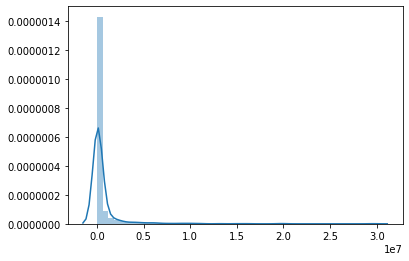

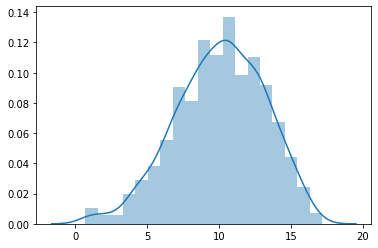

<Figure size 432x288 with 0 Axes>

In [153]:
# Checking distribution for one feature---reusing code from Juber
ax=sns.distplot(df['TOTAL_AFFECTED'].values)

plt.show()
plt.clf()

log_affected=np.log(df['TOTAL_AFFECTED'].values)
ax=sns.distplot(log_affected)

plt.show()
plt.clf()

In [154]:
# Creating list of features to transform, for skew values above 2.02

feats_to_log = skewness[skewness['Skew'] > 2.02].index

In [155]:
feats_to_log

Index(['V_LAND_KN', 'TOTAL_DEATHS', 'TOTAL_DAMAGE_(000$)', 'TOTAL_AFFECTED',
       '96KN_POP', 'Arable land (hectares per person)', 'POP_MAX_50_ADJ',
       'TOTAL_HOURS_IN_LAND', 'POP_MAX_64_ADJ', 'POP_MAX_34_ADJ', '64KN_POP',
       'CALC_assets_emdat', 'MIN_DIST2LAND',
       'Adjusted savings: education expenditure (% of GNI)',
       'Net flows from UN agencies US$'],
      dtype='object')

In [156]:
# as log cannot be perfomed to negative numbers, a common technique for handling negative values is to 
# add a constant value to the data prior to applying the log transform. The transformation is 
#therefore log(Y+a) where a is the constant. Some people like to choose a so that min(Y+a) is a very small 
#positive number (like 0.001). Others choose a so that min(Y+a) = 1. For the latter choice, you can show 
# that a = b – min(Y), where b is either a small number or is 1.
# Source : https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html

for item in feats_to_log:
    #df[item]=np.log((df[item] + 1 - df[item].min()).values)
    df[item] = df[item].apply(lambda x: np.log(x) if x>0 else 0)
    

In [157]:
df[feats_to_log].describe()

,V_LAND_KN,TOTAL_DEATHS,TOTAL_DAMAGE_(000$),TOTAL_AFFECTED,96KN_POP,Arable land (hectares per person),POP_MAX_50_ADJ,TOTAL_HOURS_IN_LAND,POP_MAX_64_ADJ,POP_MAX_34_ADJ,64KN_POP,CALC_assets_emdat,MIN_DIST2LAND,Adjusted savings: education expenditure (% of GNI),Net flows from UN agencies US$
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,4.440666,2.581518,7.634230,10.086995,4.178269,-2.198147,13.440581,1.894751,11.811131,14.579118,8.124430,19.169811,0.878179,1.041226,12.844241
std,0.445265,1.897505,5.631716,3.102598,6.142951,0.895685,5.166569,1.581078,5.680212,4.828227,7.289062,11.197377,1.706180,0.495848,7.012986
min,3.401197,0.000000,0.000000,0.693147,0.000000,-5.423870,0.000000,-0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,-0.618261,0.000000
25%,4.138361,1.098612,0.000000,8.018896,0.000000,-2.814166,13.210954,0.000000,11.292152,14.467834,0.000000,17.291178,0.000000,0.609766,13.845069
50%,4.497585,2.484907,9.680344,10.308953,0.000000,-2.362625,15.077483,1.791759,14.019712,16.057954,11.513145,24.508645,0.000000,1.029619,16.325922
75%,4.747537,3.850148,12.206073,12.413181,10.945113,-1.642416,16.525255,3.178054,15.435987,17.208886,15.194754,26.779700,0.000000,1.451725,17.263907
max,11.614498,11.837658,18.643824,17.204028,17.419063,1.121473,19.590919,5.808142,18.491778,19.746421,17.919354,30.327386,5.293305,2.639771,19.029087


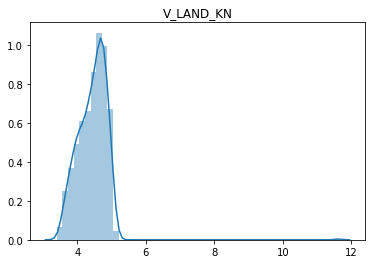

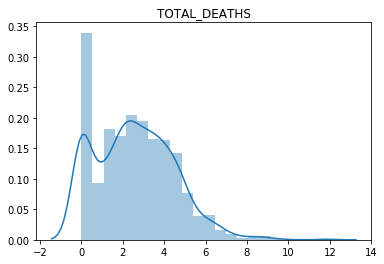

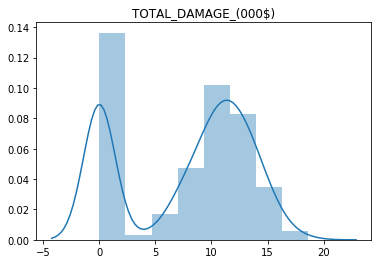

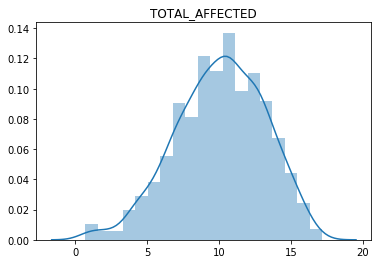

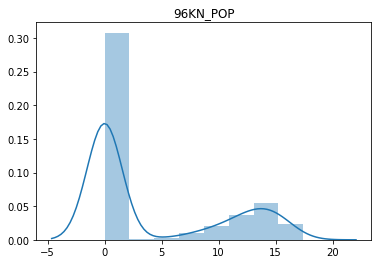

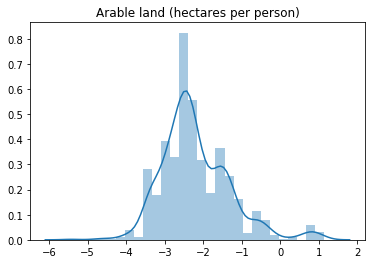

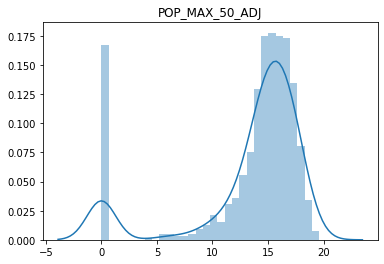

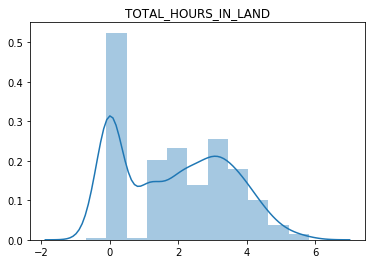

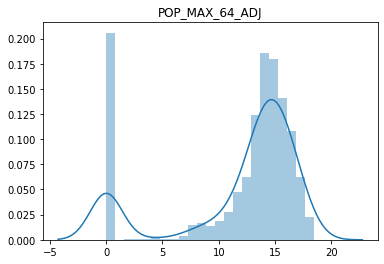

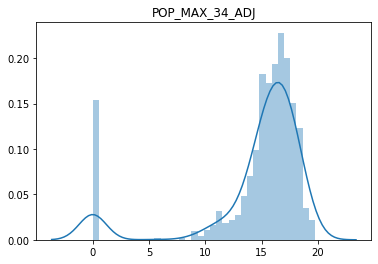

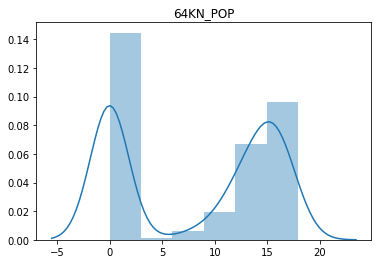

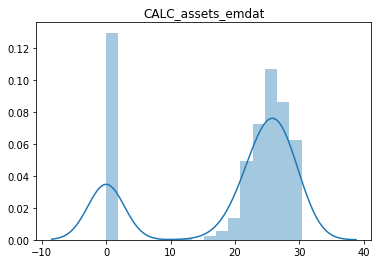

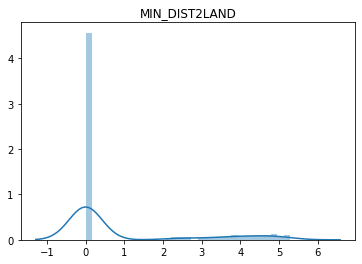

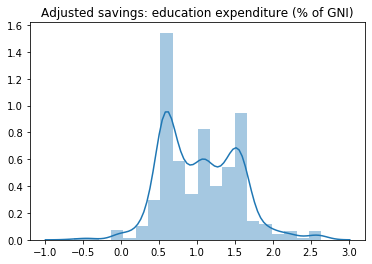

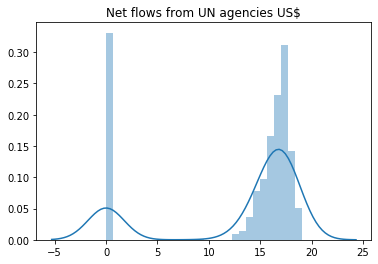

<Figure size 432x288 with 0 Axes>

In [158]:
for item in feats_to_log:
    ax=sns.distplot(df[item].values)
    ax.set_title(item);
    plt.show()
    plt.clf()


In [159]:
df.describe()

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,989.000000,991.000000,773.000000,991.000000,...,987.000000,982.000000,991.000000,987.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,7.770938,89.267238,1.894751,86.881699,939.110999,0.878179,18.303832,1.776993,0.815006,4.440666,...,93.329764,9911.140931,12.844241,70.304835,1.041226,2.454087,14.579118,13.440581,11.811131,10.086995
std,2.766138,73.284572,1.581078,33.635653,137.722579,1.706180,9.563449,1.913196,1.620204,0.445265,...,29.318225,15185.727417,7.012986,7.495767,0.495848,0.947970,4.828227,5.166569,5.680212,3.102598
min,1.000000,0.000000,-0.693147,0.000000,0.000000,0.000000,0.000000,-6.000000,-6.000000,3.401197,...,13.360000,141.276363,0.000000,41.762000,-0.618261,1.000000,0.000000,0.000000,0.000000,0.693147
25%,7.000000,33.000000,0.000000,60.000000,937.000000,0.000000,13.000000,0.000000,0.000000,4.138361,...,76.160000,1412.947077,13.845069,66.511671,0.609766,2.000000,14.467834,13.210954,11.292152,8.018896
50%,8.000000,75.000000,1.791759,85.000000,960.000000,0.000000,16.000000,1.000000,0.000000,4.497585,...,98.770000,2605.425404,16.325922,70.802000,1.029619,2.000000,16.057954,15.077483,14.019712,10.308953
75%,10.000000,123.000000,3.178054,115.000000,980.000000,0.000000,21.000000,4.000000,2.000000,4.747537,...,113.950000,8918.568543,17.263907,75.087500,1.451725,3.000000,17.208886,16.525255,15.435987,12.413181
max,12.000000,516.000000,5.808142,185.000000,1013.000000,5.293305,69.000000,5.000000,5.000000,11.614498,...,202.377089,86150.462210,19.029087,84.099756,2.639771,4.000000,19.746421,19.590919,18.491778,17.204028


- **Apply min_max_scaler**

In [ ]:
#df.shape

In [ ]:
'''
# first we split df into categorical and numerical features, to merge later
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')
'''

In [ ]:
# min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
# cols_num = df_num.columns #we'll use this later
# cols_num

In [ ]:
# X = df_num.values
# x_scaled = min_max_scaler.fit_transform(X)
# df_num = pd.DataFrame(x_scaled)

In [ ]:
# df_num.head()

In [ ]:
# df_num.rename(columns = dict(zip(df_num.columns, cols_num)), inplace = True)

In [ ]:
# df_num.head(5)

In [ ]:
# df_num.shape

In [ ]:
# df_cat.shape

Merging again df_num and df_cat

In [ ]:
# df_scaled = pd.merge(df_cat, df_num, how='inner', left_index=True, right_index=True)

In [ ]:
# df_scaled.head(20)

In [ ]:
# df_scaled.shape

- **One hot encoding for categorical variables**

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 38 columns):
BASIN                                                 991 non-null category
SUB BASIN                                             991 non-null category
NATURE                                                991 non-null category
MONTH_START                                           991 non-null int64
TOTAL_HOURS_EVENT                                     991 non-null float64
TOTAL_HOURS_IN_LAND                                   991 non-null float64
GENERAL_CATEGORY                                      991 non-null category
MAX_WIND                                              991 non-null float64
MIN_PRES                                              991 non-null int64
MIN_DIST2LAND                                         991 non-null float64
MAX_STORMSPEED                                        989 non-null float64
MAX_USA_SSHS                                          991 non-null int

In [161]:
cat_feats = df.dtypes[df.dtypes == 'category'].index
cat_feats

Index(['BASIN', 'SUB BASIN', 'NATURE', 'GENERAL_CATEGORY'], dtype='object')

In [162]:
feats_to_dummy = cat_feats #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df,dummy], axis=1)

In [163]:
# Dropping dummed features
df = df.drop(feats_to_dummy, axis=1)

In [164]:
df.columns

Index(['MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'Landing', 'TOTAL_DEATHS',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'TOTAL_AFFECTED', 'BASIN_EP', 'BASIN_NAm', 'BASIN_NI',
       'BASIN_SI', 'BASIN_SP', 'BASIN_WP', 'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB

In [165]:
df.shape

(991, 65)

In [166]:
#Droping Basin and keeping subBasin because has higher granularity,
#column arrangement 
df = df[[
    
     # here columns from cyclones dataset:
    'MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
        'Landing', 
    'BASIN_EP', 'BASIN_NAm', 'BASIN_NI',
       'BASIN_SI', 'BASIN_SP', 'BASIN_WP', 'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB BASIN_EP',
       'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI', 'SUB BASIN_SP',
       'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX',
       'NATURE_NR', 'NATURE_SS', 'NATURE_TS', 'GENERAL_CATEGORY_Cat 1',
       'GENERAL_CATEGORY_Cat 2', 'GENERAL_CATEGORY_Cat 3',
       'GENERAL_CATEGORY_Cat 4', 'GENERAL_CATEGORY_Cat 5',
       'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
    
    'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'TOTAL_DEATHS',

         
    # here columns from World Bank Indicators dataset:
    'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
         
    #  here columns from climada:
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',

    # Target   
       'TOTAL_AFFECTED']]

In [167]:
df.shape

(991, 65)

### Feature selection

In [236]:
# choosing the features to include in the model
# We take out 'TOTAL_DEATHS' because this input will not be available at the time of prediction, 


features1 = [   
     # here columns from cyclones dataset:
    'MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', 'Landing', 
            #'34KN_POP', '64KN_POP', '96KN_POP',
            # 'BASIN_EP', 'BASIN_NAm', 'BASIN_NI','BASIN_SI', 'BASIN_SP', 'BASIN_WP', 
    'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB BASIN_EP',
       'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI', 'SUB BASIN_SP',
       'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX',
       'NATURE_NR', 'NATURE_SS', 'NATURE_TS', 'GENERAL_CATEGORY_Cat 1',
       'GENERAL_CATEGORY_Cat 2', 'GENERAL_CATEGORY_Cat 3',
       'GENERAL_CATEGORY_Cat 4', 'GENERAL_CATEGORY_Cat 5',
       'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
    
                #'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 
                #'TOTAL_DEATHS',

         
    # here columns from World Bank Indicators dataset:
    'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
         
    #  here columns from climada:
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',
         ]

In [237]:
# choosing the features to include in the model
# We take out 'TOTAL_DEATHS' because this input will not be available at the time of prediction, 
# also deleding columns with high nans

features2 = [   
     # here columns from cyclones dataset:
    'MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
        'Landing', 
            # 'BASIN_EP', 'BASIN_NAm', 'BASIN_NI','BASIN_SI', 'BASIN_SP', 'BASIN_WP', 
    'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB BASIN_EP',
       'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI', 'SUB BASIN_SP',
       'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX',
       'NATURE_NR', 'NATURE_SS', 'NATURE_TS', 'GENERAL_CATEGORY_Cat 1',
       'GENERAL_CATEGORY_Cat 2', 'GENERAL_CATEGORY_Cat 3',
       'GENERAL_CATEGORY_Cat 4', 'GENERAL_CATEGORY_Cat 5',
       'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
    
    #'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 
                #'TOTAL_DEATHS',

         
    # here columns from World Bank Indicators dataset:
    'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
         
    #  here columns from climada:
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',
         ]

In [238]:
'''
features_boruta = [ 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN', 
                   'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', 
                   'Cereal yield (kg per hectare)', 'Food production index (2004-2006 = 100)', 'GDP growth (annual %)', 
                   'GDP per capita (constant 2010 US$)', 'Life expectancy at birth, total (years)', 
                   'Mobile cellular subscriptions (per 100 people)', 'Population density (people per sq. km of land area)', 
                   'Adjusted savings: education expenditure (% of GNI)', 
                   'Rural population (% of total population)', 
                   'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj']
'''

"\nfeatures_boruta = [ 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN', \n                   'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', \n                   'Cereal yield (kg per hectare)', 'Food production index (2004-2006 = 100)', 'GDP growth (annual %)', \n                   'GDP per capita (constant 2010 US$)', 'Life expectancy at birth, total (years)', \n                   'Mobile cellular subscriptions (per 100 people)', 'Population density (people per sq. km of land area)', \n                   'Adjusted savings: education expenditure (% of GNI)', \n                   'Rural population (% of total population)', \n                   'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj']\n"

In [239]:
df = df[df['TOTAL_AFFECTED'] >0]

In [240]:
#some checks....
df['SUB BASIN_NAm'].unique()

array([0, 1], dtype=uint64)

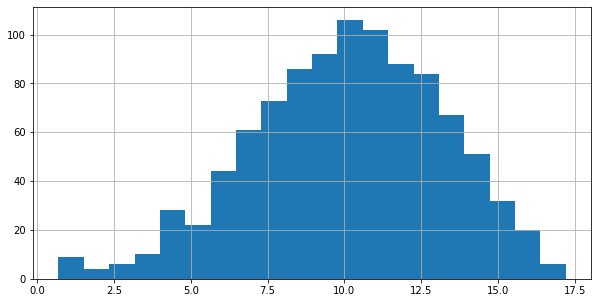

In [241]:
#some checks....
df['TOTAL_AFFECTED'].hist(bins=20, figsize=(10,5)) #this is logarithmic and scaled(0,1)

__________________

________________________

## Random forest model____________________________________

In [ ]:
 #trim. Scaled and logged 1000 < x <5000000
# df_scaled =  df_scaled[df_scaled['TOTAL_AFFECTED'] > 0.4] 
# df_scaled =  df_scaled[df_scaled['TOTAL_AFFECTED'] < 0.9]
df.shape

In [ ]:
# df_scaled.dropna(inplace = True)

In [242]:
from sklearn.impute import KNNImputer

In [243]:
df.shape

(991, 65)

In [244]:
imputer = KNNImputer(n_neighbors=5)
df_filled = pd.DataFrame(imputer.fit_transform(df))
df_filled.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,6.0,117.0,4.094345,116.0,952.0,0.0,33.0,3.0,0.0,4.603369,...,67.79,8607.657082,0.0,67.666098,1.053572,1.0,16.298999,15.574055,15.015749,12.175851
1,8.0,141.0,3.044522,116.0,940.0,0.0,31.0,3.0,1.0,4.603369,...,67.79,8607.657082,0.0,67.666098,1.053572,1.0,17.268928,16.562266,16.136855,13.372526
2,8.0,15.0,1.098612,110.0,0.0,0.0,17.0,3.0,3.0,4.885828,...,69.93,3796.219401,0.0,64.770000,0.947132,1.0,14.339791,14.338512,13.993700,9.913438
3,12.0,231.0,3.583519,120.0,924.0,0.0,11.0,4.0,2.0,4.780803,...,25.68,1059.467412,0.0,61.105000,1.014409,2.0,15.375766,14.916344,13.924162,11.002100
4,7.0,84.0,2.197225,110.0,968.0,0.0,15.0,3.0,1.0,11.614498,...,25.68,1059.467412,0.0,61.105000,1.014409,2.0,15.450771,14.841368,14.502903,4.634729


In [246]:
df_filled = df_filled.rename(columns = dict(zip(df_filled.columns, df.columns), inplace = True))

In [247]:
X = df_filled[features1] #features

y = df_filled['TOTAL_AFFECTED']

In [248]:
X.shape

(991, 52)

In [249]:
# X.to_csv(r'Data_output/X.csv', index = False, sep = ';')

In [250]:
def RF_model(X_train, X_test, y_train, y_test):
    
    estimator_RF = RandomForestRegressor(n_estimators=1000)
    estimator_RF.fit(X_train,y_train)
    print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
    print("--------------------------------------------")
    y_pred = estimator_RF.predict(X_test)
    print("------Feature importances---------------------")
    print(estimator_RF.feature_importances_)
    print("--------------------------------------------")
    score_estimator = estimator_RF.score(X_test, y_test)
    print("R-squared for test set =", score_estimator)
    mse = mean_squared_error(y_test,y_pred)
    print("RF estimator mean_squared_error = ", mse)
    rmse = math.sqrt(mse)
    print("RF estimator root_mean_squared_error = ", rmse)
    cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
    print("cross_val =neg_root_mean_squared_error mean = ", cvs)
    
    
    ##################### Plotting results #########################
    df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
    df_y['Pred_Total_Affected'] = y_pred 
    df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
    df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
    plt.figure(figsize=(12,8))
    plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
    plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
    plt.xlabel('Observations')
    plt.ylabel('log(Num_Affected')
    plt.title('log(Num Affected) - Test Vs Predictions')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()
    
    feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )
      
    return

R-squared for train set: 0.74
--------------------------------------------
------Feature importances---------------------
[1.83333608e-02 2.94386345e-02 2.91443088e-02 2.26299433e-02
 5.63114241e-02 6.85870314e-03 3.58565868e-02 4.58701367e-03
 3.82799989e-02 4.44217611e-02 2.52188411e-02 2.98351278e-02
 8.96488890e-04 7.26885333e-05 9.03533660e-04 2.22616034e-05
 1.93453846e-03 1.36160040e-04 1.00355852e-03 2.14128115e-03
 2.10235838e-03 5.87809456e-04 3.49123684e-04 5.82810781e-05
 2.21168596e-03 1.94611249e-04 9.04175356e-04 1.09868659e-04
 5.59175831e-04 6.08883670e-06 1.41862353e-03 3.41524305e-03
 3.58589437e-03 1.79032139e-03 1.43534942e-03 6.27864894e-04
 5.47211702e-04 2.04092069e-03 5.42960785e-02 1.09795625e-01
 2.96660893e-02 3.26000319e-02 3.21260611e-02 4.25121969e-02
 4.58697798e-02 5.03285604e-02 2.48829028e-02 3.78838429e-02
 2.42733998e-03 5.46330341e-02 5.58288077e-02 5.71788271e-02]
--------------------------------------------
R-squared for test set = 0.392368736968

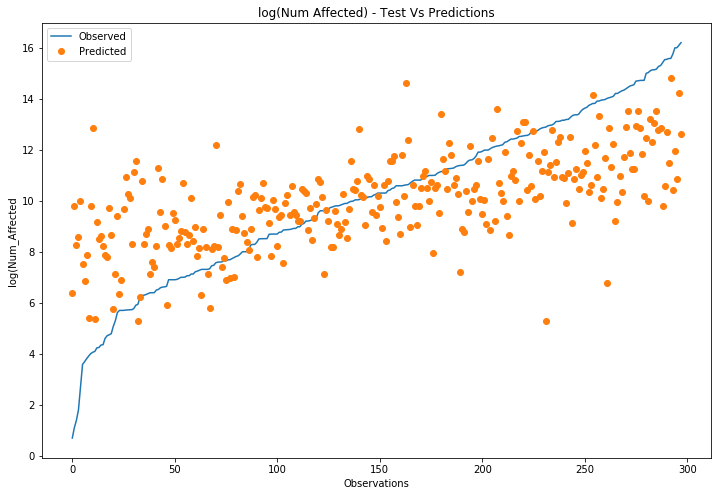

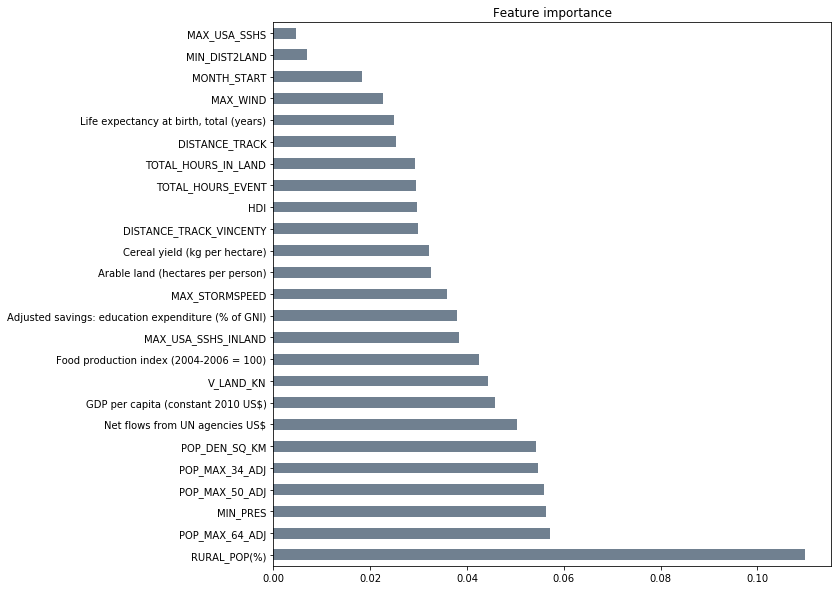

In [251]:
# Applying train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# calling the function that biulds, fits and shows results
RF_model(X_train, X_test, y_train, y_test)

# PCA______________________

# need for scaling before applying PCA

In [252]:
#from sklearn.decomposition import PCA

In [253]:
#X.shape

In [254]:
# pca = PCA(n_components=1)
# principalComponents = pca.fit_transform(X)
#X_pca = pd.DataFrame(data = principalComponents)
             #, columns = ['pc1', 'pc2'])

In [255]:
#pca.explained_variance_ratio_.sum()

In [256]:
#X_pca.head()

... let's try the Random Forest model using the PCAs as features

In [257]:
# Applying train/test split
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3)

In [258]:
'''
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)
print(f"R-squared for train set: {estimator_RF.score(X_pca, y):.2f}")
print("--------------------------------------------")
y_pred = estimator_RF.predict(X_test)
print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)
print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)
mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)
rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)
cvs = cross_val_score(estimator_RF, X_pca, y).mean()
print("cross_val_score R-squared mean = ", cvs)
'''

'\nestimator_RF = RandomForestRegressor(n_estimators=1000)\nestimator_RF.fit(X_train,y_train)\nprint(f"R-squared for train set: {estimator_RF.score(X_pca, y):.2f}")\nprint("--------------------------------------------")\ny_pred = estimator_RF.predict(X_test)\nprint("------Feature importances---------------------")\nprint(estimator_RF.feature_importances_)\nprint("--------------------------------------------")\nscore_estimator = estimator_RF.score(X_test, y_test)\nprint("R-squared for test set =", score_estimator)\nmse = mean_squared_error(y_test,y_pred)\nprint("RF estimator mean_squared_error = ", mse)\nrmse = math.sqrt(mse)\nprint("RF estimator root_mean_squared_error = ", rmse)\ncvs = cross_val_score(estimator_RF, X_pca, y).mean()\nprint("cross_val_score R-squared mean = ", cvs)\n'

In [259]:
'''
##################### Plotting results #########################

df_y = pd.DataFrame(y_test)
df_y['Pred_Total_Affected'] = y_pred
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
# plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('Num_Affected')
plt.title('Num Affected - Test Vs Predictions')
# show a legend on the plot
plt.legend()

# Display  figure
plt.show()
'''

"\n##################### Plotting results #########################\n\ndf_y = pd.DataFrame(y_test)\ndf_y['Pred_Total_Affected'] = y_pred\ndf_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot\ndf_y.reset_index(inplace=True, drop=True) #Resetting index\n    \n# plt for the Random Forest Regression results ++\nplt.figure(figsize=(12,8))\nplt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')\nplt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')\nplt.xlabel('Observations')\nplt.ylabel('Num_Affected')\nplt.title('Num Affected - Test Vs Predictions')\n# show a legend on the plot\nplt.legend()\n\n# Display  figure\nplt.show()\n"

### Hyperparameter tunning with grid search

In [260]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [262]:
parameters = {'n_estimators':[100, 500, 1000], 
              'max_depth':[5, 10, 20],
              'max_features':[10, 15, 20]              
             }

In [263]:
estimator_RF = GridSearchCV(RandomForestRegressor(), parameters, cv = 3, scoring= 'neg_root_mean_squared_error',
                            return_train_score = False)

In [264]:
estimator_RF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [265]:
GS_results = pd.DataFrame(estimator_RF.cv_results_)
GS_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [266]:
cols_needed = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score','rank_test_score']
GS_results = GS_results[cols_needed]
GS_results.sort_values(by=['rank_test_score'], ascending = True)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,rank_test_score
21,20,15,100,-2.597123,1
14,10,15,1000,-2.597570,2
26,20,20,1000,-2.599270,3
20,20,10,1000,-2.600377,4
23,20,15,1000,-2.600745,5
17,10,20,1000,-2.602050,6
25,20,20,500,-2.603221,7
19,20,10,500,-2.603566,8
13,10,15,500,-2.604234,9
16,10,20,500,-2.604337,10


### Using best parameters from GridSearchCV to fit and predict

In [267]:
estimator_RF = RandomForestRegressor(n_estimators=1000, max_features=10, max_depth=20)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score =neg_root_mean_squared_error mean = ", cvs)

R-squared for train set: 0.73
--------------------------------------------
------Feature importances---------------------
[1.99232926e-02 3.08309928e-02 2.55496117e-02 3.34729543e-02
 4.24586482e-02 7.06848425e-03 3.00164374e-02 1.35074119e-02
 4.07295801e-02 4.11795679e-02 3.14846593e-02 3.69528187e-02
 2.60306011e-03 3.14413880e-04 2.28590862e-03 5.88306902e-05
 1.92677886e-03 2.03603176e-04 6.39474036e-04 1.21467453e-03
 1.79789542e-03 1.23898595e-03 7.54295793e-04 6.91959780e-04
 4.40216425e-03 8.66624590e-05 1.10390277e-03 1.64912422e-04
 1.10462586e-03 8.86558552e-05 1.81311002e-03 3.54135020e-03
 3.92913034e-03 1.90664862e-03 2.06492644e-03 2.52746520e-03
 1.23714214e-03 5.53586312e-03 5.19918238e-02 5.70395919e-02
 4.56950198e-02 4.24492287e-02 3.70708868e-02 3.82513746e-02
 4.83802448e-02 4.35570495e-02 3.17522835e-02 3.18706528e-02
 8.60175757e-03 5.86271658e-02 5.79348346e-02 5.03671863e-02]
--------------------------------------------
R-squared for test set = 0.332840906243

In [268]:
# df_y.to_csv(r'Data_output/ytest_Vs_ypred_YY.csv', index = False, sep = ';')

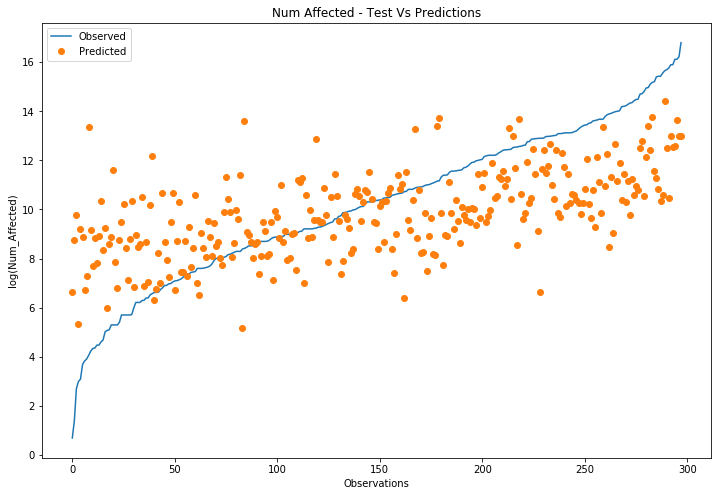

In [269]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()
    


In [270]:
df_y.to_csv(r'Data_output/ytest_Vs_ypred.csv', index = False, sep = ';')

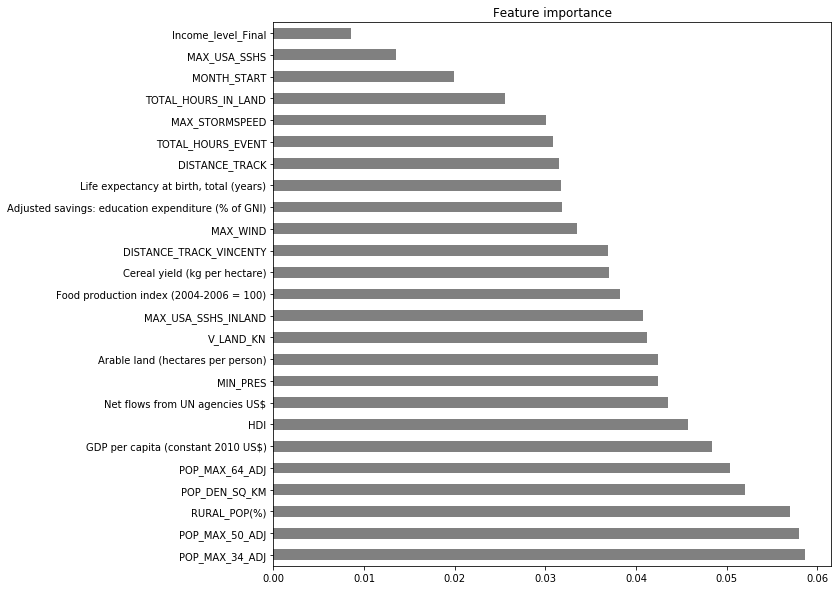

In [271]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

- Plotting with another chart

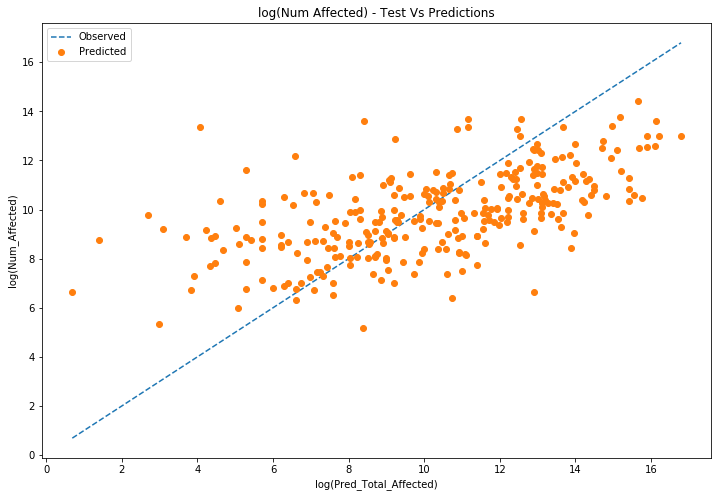

In [272]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y['TOTAL_AFFECTED'], df_y['TOTAL_AFFECTED'], '--', label = 'Observed')
plt.plot(df_y['TOTAL_AFFECTED'], df_y['Pred_Total_Affected'], 'o', label = 'Predicted')

plt.xlabel('log(Pred_Total_Affected)')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('log(Num Affected) - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

- Plotting Absolute Error of each observed data point in test data

In [273]:
df_y['error'] = abs(df_y['Pred_Total_Affected'] - df_y['TOTAL_AFFECTED'])

In [274]:
df_y['error'].describe()

count    298.000000
mean       2.041751
std        1.560997
min        0.006029
25%        0.765178
50%        1.759000
75%        2.985831
max        9.302673
Name: error, dtype: float64

No handles with labels found to put in legend.


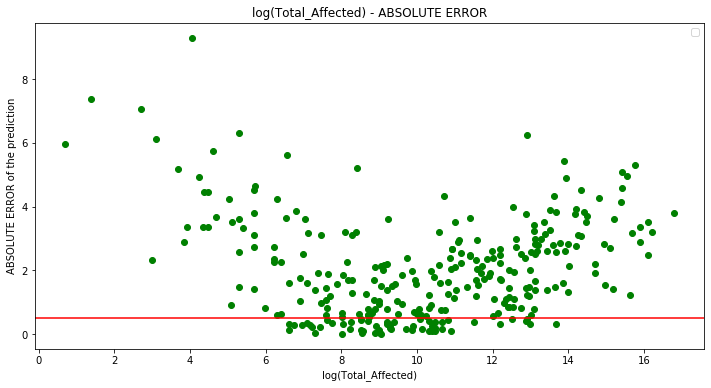

In [275]:
plt.figure(figsize=(12,6))
plt.plot(df_y['TOTAL_AFFECTED'], df_y['error'] , 'og')
plt.axhline(y=0.5,c='r')
plt.xlabel('log(Total_Affected)')
plt.ylabel('ABSOLUTE ERROR of the prediction')
#plt.xlim(0,100)
plt.title('log(Total_Affected) - ABSOLUTE ERROR')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

### Oversampling in train dataset to see if we can improve model performance in boundaries of y-values 

In [276]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [278]:
X_train['y_train'] = pd.DataFrame(y_train)

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [279]:
# oversampling only low and high values
X_train = X_train.append(X_train[X_train['y_train'] < 2]).append(X_train[X_train['y_train'] > 5])
y_train = X_train['y_train']
X_train = X_train.drop('y_train', axis = 1)

In [280]:
X_train.shape

(1351, 52)

In [281]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score =neg_root_mean_squared_error mean = ", cvs)

R-squared for train set: 0.76
--------------------------------------------
------Feature importances---------------------
[1.65433993e-02 2.85213368e-02 2.91233101e-02 2.76110698e-02
 4.89767791e-02 6.65307314e-03 3.27989296e-02 6.84623629e-03
 4.56498452e-02 5.45951294e-02 2.72742719e-02 3.06608902e-02
 9.27054652e-04 1.95851942e-04 7.60764100e-04 1.18997153e-05
 1.58737285e-03 8.43447369e-05 3.94914485e-04 1.27211365e-03
 4.41049780e-04 4.24786969e-04 3.75772501e-04 7.93047910e-04
 1.15517974e-03 2.17440432e-04 1.48416736e-03 5.54340881e-05
 8.34138305e-04 1.00480981e-04 1.52443970e-03 2.93674547e-03
 4.49598074e-03 1.25032749e-03 1.47757343e-03 5.45768693e-04
 3.08339137e-03 2.67227391e-03 5.19851990e-02 1.31463685e-01
 2.45442219e-02 3.11137241e-02 2.91644218e-02 4.00167233e-02
 4.16317150e-02 2.55592938e-02 1.97019907e-02 4.07829606e-02
 2.10538093e-03 5.51103900e-02 8.71723668e-02 3.52913410e-02]
--------------------------------------------
R-squared for test set = 0.293571688757

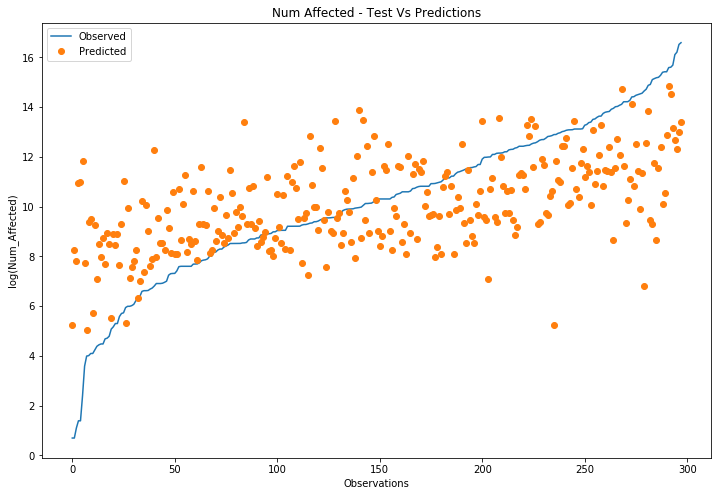

In [282]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

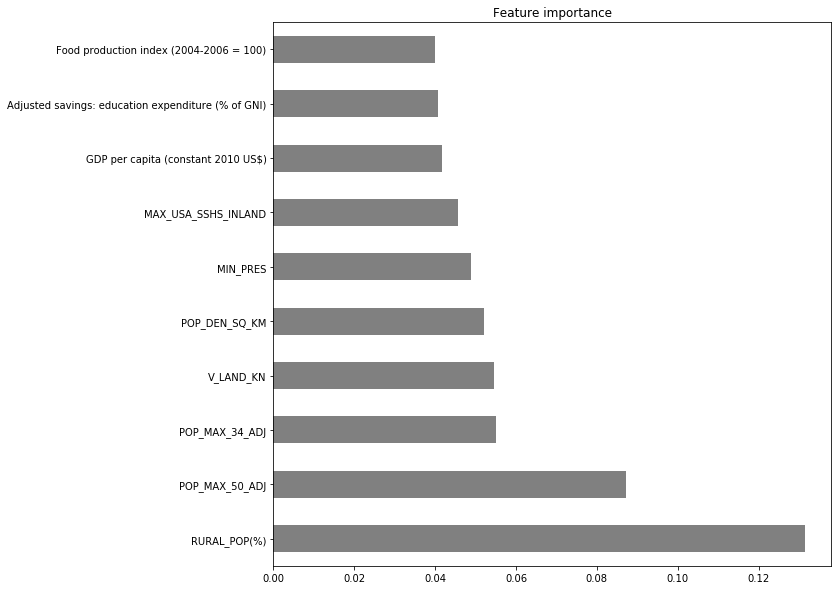

In [283]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
feat_importances.nlargest(10).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

#### __________Oversamplig strategy doesn't work____________

### Using Sequential Feature Selection

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [284]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [285]:
# df_filled =  df_filled[df_filled['TOTAL_AFFECTED'] > 0.4] 
# df_filled =  df_filled[df_filled['TOTAL_AFFECTED'] < 0.9]

In [286]:
df_filled.shape

(991, 65)

In [287]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [289]:
estimator_RF = RandomForestRegressor(n_estimators=1000)

In [290]:
sfs1 = SFS(estimator_RF, 
           k_features=10, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_root_mean_squared_error',
           cv=0)

In [291]:
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  1.6min finished

[2020-05-02 11:59:52] Features: 1/10 -- score: -1.3979242433879484[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished

[2020-05-02 12:02:27] Features: 2/10 -- score: -1.1528593195805636[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_

In [292]:
sfs1.subsets_

{1: {'feature_idx': (10,),
  'cv_scores': array([-1.39792424]),
  'avg_score': -1.3979242433879484,
  'feature_names': ('DISTANCE_TRACK',)},
 2: {'feature_idx': (10, 39),
  'cv_scores': array([-1.15285932]),
  'avg_score': -1.1528593195805636,
  'feature_names': ('DISTANCE_TRACK', 'RURAL_POP(%)')},
 3: {'feature_idx': (8, 10, 39),
  'cv_scores': array([-1.0708507]),
  'avg_score': -1.0708506950367216,
  'feature_names': ('MAX_USA_SSHS_INLAND', 'DISTANCE_TRACK', 'RURAL_POP(%)')},
 4: {'feature_idx': (3, 8, 39, 41),
  'cv_scores': array([-1.00124535]),
  'avg_score': -1.001245350927214,
  'feature_names': ('MAX_WIND',
   'MAX_USA_SSHS_INLAND',
   'RURAL_POP(%)',
   'Arable land (hectares per person)')},
 5: {'feature_idx': (2, 3, 8, 39, 41),
  'cv_scores': array([-0.97614886]),
  'avg_score': -0.9761488567062705,
  'feature_names': ('TOTAL_HOURS_IN_LAND',
   'MAX_WIND',
   'MAX_USA_SSHS_INLAND',
   'RURAL_POP(%)',
   'Arable land (hectares per person)')},
 6: {'feature_idx': (2, 3, 8, 39

In [293]:
#TOP_10 Selected features
top_10_features = list(sfs1.k_feature_names_)
top_10_features

['TOTAL_HOURS_IN_LAND',
 'MAX_WIND',
 'MAX_USA_SSHS_INLAND',
 'SUB BASIN_SP',
 'SUB BASIN_WA',
 'SUB BASIN_WP',
 'GENERAL_CATEGORY_TS',
 'RURAL_POP(%)',
 'Arable land (hectares per person)',
 'Food production index (2004-2006 = 100)']

In [294]:
# df_filled_trim =  df_filled[(df_filled['TOTAL_AFFECTED']>2) & (df_filled['TOTAL_AFFECTED']<5)]

In [295]:
X = df_filled[top_10_features] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [297]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score =neg_root_mean_squared_error mean = ", cvs)

R-squared for train set: 0.72
--------------------------------------------
------Feature importances---------------------
[0.12447476 0.17471573 0.08601503 0.00386094 0.0033308  0.01699802
 0.00695762 0.23011251 0.17923884 0.17429574]
--------------------------------------------
R-squared for test set = 0.2645970838623267
RF estimator mean_squared_error =  6.954276069246098
RF estimator root_mean_squared_error =  2.6370961433451945
cross_val_score =neg_root_mean_squared_error mean =  -2.7126957728443806


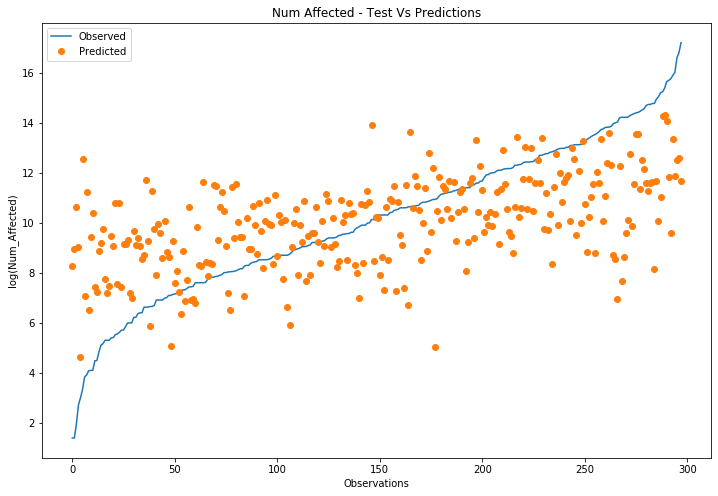

In [298]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

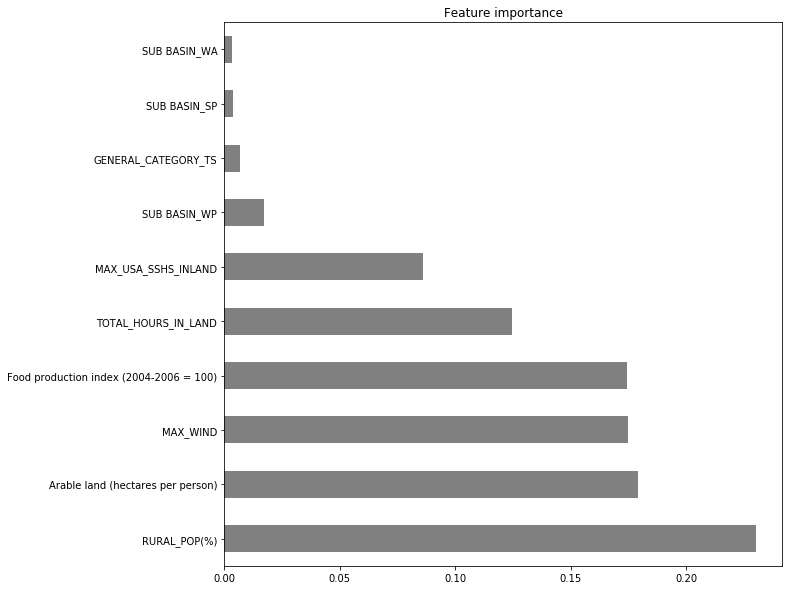

In [299]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = top_10_features)
feat_importances.nlargest(10).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

## RANSAC Regressor (works if target has outliers?)

In [300]:
from sklearn import linear_model

In [301]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X_train, y_train)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models

y_pred = ransac.predict(X_test)

In [302]:
print("--------------------------------------------")
score_estimator = ransac.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(ransac, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score mean = ", cvs)

--------------------------------------------
R-squared for test set = 0.10437963497104841
RF estimator mean_squared_error =  8.469358952724479
RF estimator root_mean_squared_error =  2.910216306861825
cross_val_score mean =  -3.5161843553050147


###  ________________**Nope, ransac doesn't work**__________________

### Correlations heatmap

In [303]:
df2 = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v12.csv', sep=";")

In [304]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 51 columns):
SID                                                   1019 non-null object
NAME                                                  1019 non-null object
ISO                                                   1019 non-null object
YEAR                                                  1019 non-null int64
COORDS                                                1019 non-null object
COORDS_MAX_WINDS                                      1019 non-null object
COORDS_MIN_DIST2LAND                                  1019 non-null object
BASIN                                                 1019 non-null object
SUB BASIN                                             1019 non-null object
MONTH_START                                           1019 non-null int64
MONTH_END                                             1019 non-null int64
DATE_START                                            1019 non-null obj

In [305]:
#Selecting the numerical features

numerical_features = list(df2.select_dtypes(include=['float64','int64']).columns)

In [306]:
#New data sets to construct the correlation matrix
df2 = df2[numerical_features]

In [307]:
#correlation matrices
corr_num = df2.corr(method = "spearman")

(35.5, -0.5)

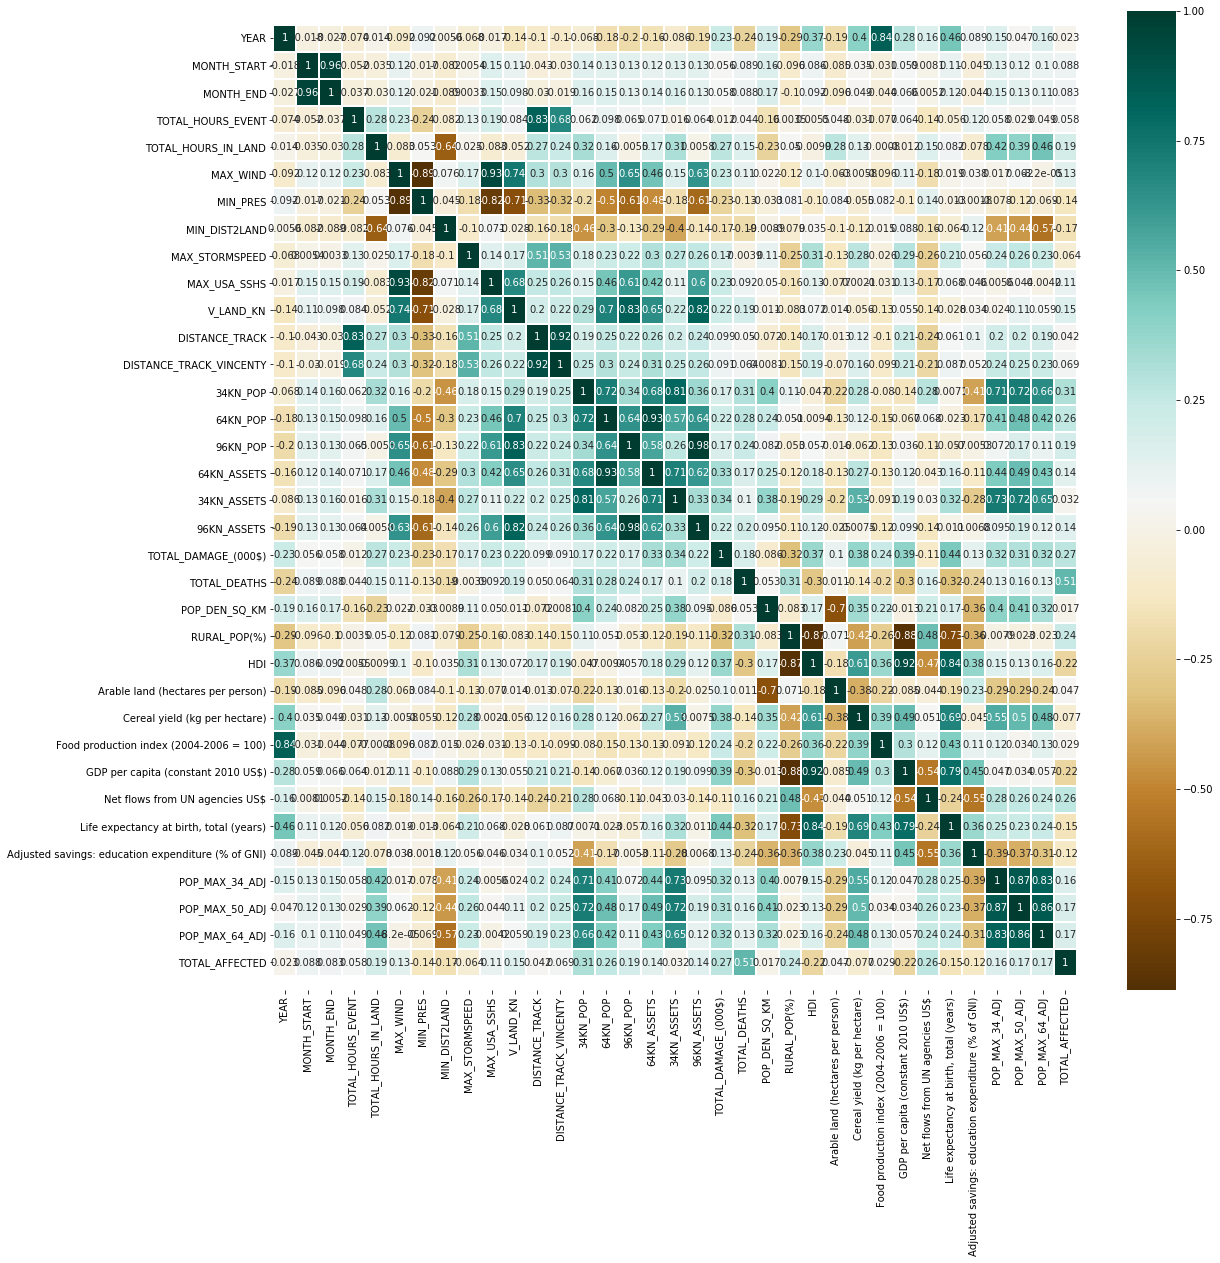

In [308]:
fig, ax = plt.subplots(figsize=(18,18))
ax = plt.subplot(111)
sns.heatmap(corr_num, annot=True, linewidth=1, cmap="BrBG", ax=ax)
bottom, top = ax.get_ylim()             # this fixes a bug where first and last columns were not visualized correctly
ax.set_ylim(bottom + 0.5, top - 0.5)

___________________________
________________________________